In [30]:
from itertools import combinations , product
from collections import Counter, defaultdict
import numpy as np
import seaborn as sns

In [2]:
import json
import pandas as pd

annotation_df = pd.read_json("annotation_data.json")

In [45]:
#For multiple annotators,
#We compute Jaccard similarity for every annotator pair and summarize agreement using the mean pairwise similarity, which scales naturally as the number of annotators increases.

#Step 1
#To identify agreement, at a ROW LEVEL, I will use Jaccard similarity pairwise between annotators and take the average similarity. I will add more metrics if time allows.
#One that I would like to add if given more time is an agreement that is depth based.
#I will use seaborn and histograms to complete my analysis for agreement.

#Step 2:
#My method for comparing groups is twofold, with the comparison being implemented in code.
#For the two groups, I would first generate all the 2 item combinations where one annotator is from each group.
#For each item in our annotations dataset, I would then calculate the jaccard similarity between each annotator combination and take the average similarity between groups.
#   Again this is a row by row calculation
#I would then analyze how our list similarities looked over the entire annotations dataset.
#I might recommend doing a consensus comparison if we had less sparse data. I will explain below.


#Step 3
#To evaluate the quality of one single annotator, Annotator X ,I would calculate the group consensus for allannotators excluding Annotator X on a row by row basis in the dataset
#Then I would calculate the jaccard similarity between X and the group consensus on a row by row basis
#Finally I would analyze the distribution and average similarity for these jaccard values.



In [18]:
#Step 0: Preprocessing
ANNOTATOR_COLS  = [
    "Barbara_labels",
    "Alanna_labels",
    "Blair_labels",
    "Andy_labels"
]


In [20]:
#Step 1: Understanding Agreement between Annotators
def expand_label(label: str) -> set[str]:
    parts = label.split("_")
    return {"_".join(parts[:i + 1]) for i in range(1, len(parts))}

def expand_annotation(label_list):
    """
    label_list:
        - list[str]
        - []
        - None / NaN
    """
    if label_list is None or (isinstance(label_list, float) and pd.isna(label_list)):
        return None

    expanded = set()
    for label in label_list:
        expanded |= expand_label(label)
    return expanded
def row_to_annotations(row, annotator_cols):
    """
    Returns:
    {
        'Barbara': {'id_01', 'id_01_02'},
        'Alanna':  {'id_01'},
        ...
    }
    """
    annotations = {}
    for col in annotator_cols:
        annotator = col.replace("_labels", "")
        annotations[annotator] = expand_annotation(row[col])
    return annotations
def jaccard_similarity(a, b):
    if not a and not b:
        return 1.0
    if not a or not b:
        return 0.0
    return len(a & b) / len(a | b)

def pairwise_agreement(annotations: dict) -> list[float]:
    scores = []

    for (_, a), (_, b) in combinations(annotations.items(), 2):
        if a is None or b is None:
            continue
        scores.append(jaccard_similarity(a, b))

    return scores



In [17]:
def analyze_row(row, annotator_cols):
    annotations = row_to_annotations(row, annotator_cols)

    pairwise_scores = pairwise_agreement(annotations)

    return pd.Series({
        "mean_pairwise_agreement": np.mean(pairwise_scores) if pairwise_scores else np.nan
    })

In [21]:
results = annotation_df.apply(analyze_row, axis=1, annotator_cols=ANNOTATOR_COLS)

annotation_df_out = pd.concat([annotation_df, results], axis=1)

In [42]:
print(annotation_df_out.describe())

print(annotation_df_out[annotation_df_out['mean_pairwise_agreement']==1].shape[0]/annotation_df_out[annotation_df_out['mean_pairwise_agreement'].notna()].shape[0])

       mean_pairwise_agreement
count                51.000000
mean                  0.627824
std                   0.323997
min                   0.000000
25%                   0.334704
50%                   0.500000
75%                   1.000000
max                   1.000000
0.37254901960784315


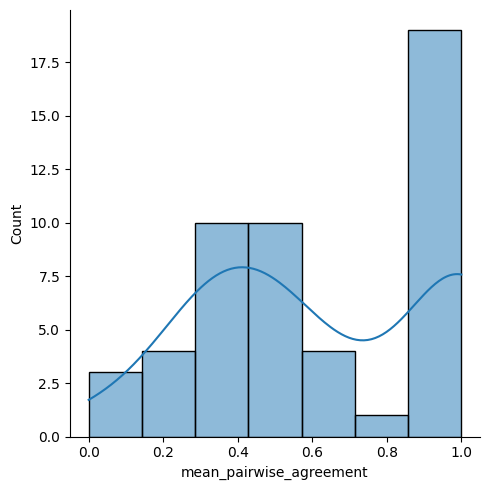

In [25]:
sns.displot( data=annotation_df_out["mean_pairwise_agreement"], kde=True )

In [ ]:
#Conclusion
#On average, we have a 62.7% similarity between labels on a case by case basis.
#37.3% of annotations are exactly the same on a case by case basis once you remove cases where we could not compare annotations due to no annotation being applied!

In [34]:
#Step 2 group similarity
def group_internal_similarity(annotations, group):
    """
    Mean pairwise Jaccard similarity within a group of annotators.

    group: list[str]
    """
    scores = []

    for a, b in combinations(group, 2):
        if annotations.get(a) is None or annotations.get(b) is None:
            continue
        scores.append(
            jaccard_similarity(annotations[a], annotations[b])
        )

    return np.mean(scores) if scores else np.nan

def group_between_similarity(annotations, group_a, group_b):
    """
    Mean Jaccard similarity across all annotator pairs
    where one annotator is from group_a and the other from group_b.
    """
    scores = []

    for a, b in product(group_a, group_b):
        if annotations.get(a) is None or annotations.get(b) is None:
            continue
        scores.append(
            jaccard_similarity(annotations[a], annotations[b])
        )

    return np.mean(scores) if scores else np.nan

def group_consensus(annotations, group, threshold=0.5):
    """
    Build a majority-vote consensus label set for a group.
    """
    counts = Counter()
    n = 0

    for annotator in group:
        labels = annotations.get(annotator)
        if labels is None:
            continue
        n += 1
        counts.update(labels)

    if n == 0:
        return set()

    return {
        label for label, count in counts.items()
        if count / n >= threshold
    }

def consensus_similarity(annotations, group_a, group_b, threshold=0.5):
    consensus_a = group_consensus(annotations, group_a, threshold)
    consensus_b = group_consensus(annotations, group_b, threshold)

    return jaccard_similarity(consensus_a, consensus_b)

In [36]:
def analyze_row_and_groups(row, annotator_cols, group_a, group_b):
    annotations = row_to_annotations(row, annotator_cols)
    # group_results = compare_groups(annotations, group_a, group_b)


    return pd.Series({
        "group_a_internal": group_internal_similarity(annotations, group_a),
        "group_b_internal": group_internal_similarity(annotations, group_b),
        "between_groups": group_between_similarity(annotations, group_a, group_b),
        "consensus_similarity": consensus_similarity(annotations, group_a, group_b)
    })

In [37]:
group_A = ["Barbara", "Andy"]
group_B = ["Alanna", "Blair"]


In [39]:
results_for_group = annotation_df.apply(analyze_row_and_groups, axis=1, annotator_cols=ANNOTATOR_COLS, group_a = group_A, group_b = group_B)

annotation_df_out_groups = pd.concat([annotation_df, results_for_group], axis=1)

In [40]:
annotation_df_out_groups.head()

,encounter_id,hsim,Barbara_labels,Alanna_labels,Blair_labels,Andy_labels,group_a_internal,group_b_internal,between_groups,consensus_similarity
0,f23b5da518fa57c384784180560a8f56f3e19129,1304200b,"{id_02_04, id_02, id_02_06, id_01}","{id_02_03_01_01, id_02_03_01, id_02_06, id_02_...",None,"{id_02_04, id_02, id_02_06}",0.75,NaN,0.190909,0.181818
1,f23b5da518fa57c384784180560a8f56f3e19129,1304220b,None,None,"{id_02, id_01}",None,NaN,NaN,NaN,0.000000
2,f2c9769e20e02e19628aafb31b15b9d9f1ea8a45,0224600b,{id_01},{id_01},{},{id_01},1.00,0.0,0.500000,1.000000
3,f36809f4da897e548ba31ed81116699da2bf730e,1498010b,None,"{id_02_01, id_02}",None,"{id_02_01, id_02}",NaN,NaN,1.000000,1.000000
4,f36809f4da897e548ba31ed81116699da2bf730e,9998040a,None,None,{},None,NaN,NaN,NaN,1.000000


In [52]:
print(annotation_df_out_groups.describe())

print(annotation_df_out_groups[annotation_df_out_groups['between_groups']==1].shape[0]/annotation_df_out_groups[annotation_df_out_groups['between_groups'].notna()].shape[0])
print(annotation_df_out_groups[annotation_df_out_groups['consensus_similarity']==1].shape[0]/annotation_df_out_groups[annotation_df_out_groups['consensus_similarity'].notna()].shape[0])

print(annotation_df_out_groups[annotation_df_out_groups['group_a_internal'].isna()].shape[0]/annotation_df_out_groups.shape[0])

print(annotation_df_out_groups[annotation_df_out_groups['group_b_internal'].isna()].shape[0]/annotation_df_out_groups.shape[0])

print(annotation_df_out_groups[annotation_df_out_groups['group_a_internal'].isna() | annotation_df_out_groups['group_b_internal'].isna()].shape[0]/annotation_df_out_groups.shape[0])

       group_a_internal  group_b_internal  between_groups  \
count         39.000000         27.000000       48.000000   
mean           0.687307          0.655041        0.595294   
std            0.359452          0.404029        0.348146   
min            0.000000          0.000000        0.000000   
25%            0.436652          0.366667        0.297917   
50%            0.833333          1.000000        0.500000   
75%            1.000000          1.000000        1.000000   
max            1.000000          1.000000        1.000000   

       consensus_similarity  
count             85.000000  
mean               0.481801  
std                0.445609  
min                0.000000  
25%                0.000000  
50%                0.500000  
75%                1.000000  
max                1.000000  
0.3541666666666667
0.36470588235294116
0.5411764705882353
0.6823529411764706
0.7294117647058823


In [ ]:
#Step 2 Conclusion
#My method for comparing groups is twofold, with the comparison being implemented in code.
#For the two groups, I would first generate all the 2 item combinations where one annotator is from each group.
#For each item in our annotations dataset, I would then calculate the jaccard similarity between each annotator combination and take the average similarity between groups.
#I would then analyze how our list similarities looked over the entire annotations dataset.
#I might recommend doing a consensus comparison if we had less sparse data.
#In this case, I would build the consensus for each group, and then calculate the similarity between the consensus of group A vs consensus of group B
# However, that would not woek here, as 73% of all rows in the annotation data have at least one member missing from the data.
#So for those rows it would be a comparison of a group vs one annotator. Which is not ideal